

# Analysing the Indian start-up ecosystem





In this project we analyze funding received by start-ups in the  India start-up ecosystem from 2018 to 2021.
The dataset for 2018 and 2019 is in CSV format and 2020 and 2021 datasets are SQL files that will be imported from the server


# Hypothesis

Null Hypothesis :The location of a sector does not have an impact on the amount of funding

Alternate Hypothesis : The location of a sector has an impact on the amount of funding

Analytical Questions

1. Which Head quarter has the most populated start up location
2. Top 10 headquarters that has the highest start up funding
3. Top 10 sectors that receive the highest start up funding
4. Which year received the highest funding
5. What is the funding trend in the Indian start-up ecosystem over the past few years

#  Step 1



Importation of all the needed libraries and dataset

In [170]:
# Neccesary liberaries
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
from scipy import stats
import statistics as stat
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

 
warnings.filterwarnings('ignore')

In [171]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
 
 
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [172]:
# code to connect the sever, database, username and passward
conn_str =f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [173]:
# conection to the server
connection = pyodbc.connect(conn_str)


In [174]:
# import the 2020 and 2021 SQL file from the server
query1 = "Select * from LP1_startup_funding2020"
data_2020 = pd.read_sql(query1, connection)
 
query2 = "Select * from LP1_startup_funding2021"
data_2021 = pd.read_sql(query2, connection)

In [175]:
# 2019 CSV data
data_2019 = pd.read_csv('startup_funding2019.csv')

In [176]:
# 2018 CSV data
data_2018 = pd.read_csv('startup_funding2018.csv')

In [177]:
# to add year column to all the imported data
data_2018['Year']='2018'
data_2019['Year']='2019'
data_2020['Year']='2020'
data_2021['Year']='2021'

#  Step 2

cleaning and concating the two CSV files 2018 and 2019

In [178]:
# Drop the Colunms that we may not need for the project

data_2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)

In [179]:
# Select specific columns and rename them

data_2018 = data_2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
data_2019 = data_2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})

Hamornizing the stage column in 2018 & 2019

Some of the data in the stage column are named differently but the still do serve the same purpose so we group them together and give them one common name foe easy analysis

In [180]:
data_2018.head()

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,Year
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,2018
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,2018
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,2018


<b>Harmonising the HeadQuater/Location column entries in 2018&2019 data.<b>

some of the locations  in the headquarter  has spelling error, some are the same location with different names while some are outside india so he group them and give them common name for easy analysis 

In [181]:
# code to sparete the headquarters in 2018 because the columns contain more than one headquarter which will affect the analysis
data_2018_new=data_2018['HeadQuarter'].str.split(pat=',', n=1, expand=True) 
data_2018['Head']=data_2018_new[0]

In [182]:
# drop headquarter column
data_2018.drop(['HeadQuarter'], axis=1, inplace=True)
# rename the head column
data_2018.rename(columns={'Head':'HeadQuarter'}, inplace=True)

In [183]:
# data cleaning of headquarter in 2018
data_2018.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2018.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2018.replace(to_replace=['Cochin'], value='Kochi', inplace=True)
data_2018.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2018.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2018.replace(to_replace=['Uttar Pradesh', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
data_2018.replace(to_replace=['Trivandrum', 'India'], value='Trivandrum', inplace=True)


# data cleaning of headquarter in 2019
data_2019.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)

<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df2018 & df2019<b>

In [184]:
data_2018.duplicated().value_counts()

False    525
True       1
Name: count, dtype: int64

In [185]:
data_2018.drop_duplicates(keep='first', inplace=True)

In [186]:
data_2019.duplicated().value_counts()

False    89
Name: count, dtype: int64

# Step 3 

Merging 2018 & 2019 and Checking for currency

In the currency colunn in 2018 and 2019 some amount are in  Dollar, some are in Rupee while sum are just numeric so we converted all of them to Dollar for easy analysis

In [187]:
# Merge the two csv files 

data_18_19 = pd.concat([data_2018, data_2019], ignore_index=True)

In [188]:
# Create a new column 'currency' based on currency symbols

data_18_19['currency'] = data_18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))

# Create columns 'amount_inr' and 'amount_usd'

data_18_19['amount_inr'] = data_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
data_18_19['amount_usd'] = data_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

# Remove the currency sysmbols and the commas 

data_18_19['amount_inr'] = data_18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
data_18_19['amount_usd'] = data_18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

# Replace 'Undisclosed' values with NaN

data_18_19['amount_inr'] = data_18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
data_18_19['amount_usd'] = data_18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

# Convert the object values into numeric values for calculation

data_2018['amount_inr'] = pd.to_numeric(data_18_19['amount_inr'], errors='coerce')
data_2019['amount_usd'] = pd.to_numeric(data_18_19['amount_usd'], errors='coerce')

# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'
data_18_19['Updated_Amount'] = data_18_19['amount_inr'].fillna(data_18_19['amount_usd'])

In [189]:
data_18_19.drop(['currency','amount_inr','amount_usd','Amount'], axis=1, inplace=True)

In [190]:
data_18_19.rename(columns={'Updated_Amount':'Amount'}, inplace=True )

In [191]:
data_18_19.duplicated().value_counts()

False    614
Name: count, dtype: int64

In [192]:
data_18_19.drop_duplicates(keep='first', inplace=True)

In [193]:
data_18_19.head()

,Company_Brand,Sector,Stage,BIO,Year,HeadQuarter,Amount
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,"TheCollegeFever is a hub for fun, fiesta and f...",2018,Bangalore,250000
1,Happy Cow Dairy,"Agriculture, Farming",Seed,A startup which aggregates milk from dairy far...,2018,Mumbai,40000000
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,Leading Online Loans Marketplace in India,2018,Gurgaon,65000000
3,PayMe India,"Financial Services, FinTech",Angel,PayMe India is an innovative FinTech organizat...,2018,Noida,2000000
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,Eunimart is a one stop solution for merchants ...,2018,Hyderabad,—


# Step 4

Cleaning and concating the two SQL file 2020 & 2021

In [194]:
# Renaming the Column to have the same column names for all the tables

data_2020 = data_2020.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'Location':'HeadQuarter'})
data_2021 = data_2021.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'HeadQuarter':'HeadQuarter'})

<b> Drop some columns that might not be needed for the analysis like founded, founders, investors and column10 which is not also included in 2018 file <b>

In [195]:
data_2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data_2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data_2020.drop(columns=['column10'], inplace=True)

<b>Harmonising the HeadQuarter column entries in 2020&2021 data.<b>

In [196]:
#
#  cleaning of HeadQuater 2020
data_2020.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2020.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2020.replace(to_replace=['Ahmadabad'], value='Ahmedabad', inplace=True)
data_2020.replace(to_replace=['Kochi'], value='Cochin', inplace=True)
data_2020.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2020.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2020.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2020.replace(to_replace=['Small Towns', 'Andhra Pradesh','Uttar Pradesh'], value='Andhra Pradesh', inplace=True)
data_2020.replace(to_replace=['Hyderebad'], value='Hyderabad', inplace=True)
data_2020.replace(to_replace=['Gurugram\t#REF!'], value='Gurugram', inplace=True)
data_2020.replace(to_replace=['Orissia'], value='Orissa', inplace=True)
data_2020.replace(to_replace=['Samstipur','Samastipur, Bihar','Samsitpur'], value='Samastipur', inplace=True)
data_2020.replace(to_replace=['The Nilgiris'], value='Nilgiris', inplace=True)
data_2020.replace(to_replace=['Dhindsara', 'Haryana','Dhingsara, Haryana'], value='Dhingsara', inplace=True)
data_2020.replace(to_replace=['Tirunelveli', 'Tamilnadu'], value='Tirunelveli', inplace=True)
data_2020.replace(to_replace=['Mylapore'], value='Chennai', inplace=True)
data_2020.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2020.replace(to_replace=['Trivandrum', 'Kerala, India'], value='Trivandrum', inplace=True)


#  Renaming some of the headquarters the are not in India to outside india in data 2020
data_2020.replace(to_replace=['Frisco', 'France','Newcastle Upon Tyne, Newcastle upon Tyne, United Kingdom',
                              'Frisco, Texas, United States','Irvine, California, United States',
                              'San Francisco Bay Area, West Coast, Western US','Texas, United States','California',
                              'New York, United States','San Francisco, California, United States','San Francisco, United States',
                              'San Ramon, California','Paris, Ile-de-France, France','Plano, Texas, United States','Sydney',
                              'San Francisco Bay Area, Silicon Valley, West Coast','Bangaldesh','London, England, United Kingdom','Sydney, New South Wales, Australia',
                              'Milano, Lombardia, Italy','Palmwoods, Queensland, Australia', 'France''Irvine, California, United States',
                              'Newcastle Upon Tyne, Newcastle upon Tyne United Kingdom','Shanghai, China','Jiaxing, Zhejiang, China',
                              'San Franciscao','San Francisco','New York'], value = 'Outside India', inplace=True)


# filling of missing headquarters in 2020
data_2020['HeadQuarter'].fillna('Undisclosed', inplace=True)

In [197]:
data_2020['HeadQuarter'].unique()

array(['Chennai', 'Bangalore', 'Pune', 'Delhi', 'Indore', 'Hyderabad',
       'Gurgaon', 'Belgaum', 'Noida', 'Mumbai', 'Andheri', 'Jaipur',
       'Ahmedabad', 'Kolkata', 'Tirunelveli, Tamilnadu', 'Thane',
       'Undisclosed', 'Singapore', 'Gurugram', 'Gujarat', 'Dhingsara',
       'Kerala', 'Jodhpur', 'Jaipur, Rajastan', 'Outside India', 'Patna',
       'Trivandrum, Kerala, India', 'Cochin', 'Samastipur',
       'Tumkur, Karnataka', 'Rajasthan', 'Ludhiana', 'Dehradun',
       'Tangerang, Jawa Barat, Indonesia', 'Berlin', 'Seattle', 'Riyadh',
       'Seoul', 'Bangkok', 'Kanpur', 'Chandigarh', 'Warangal', 'Odisha',
       'Bihar', 'Goa', 'Tamil Nadu', 'Andhra Pradesh', 'Bhopal',
       'Banglore', 'Coimbatore', 'Bengaluru'], dtype=object)

In [198]:
#  cleaning of HeadQuater 2021
data_2021.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
data_2021.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
data_2021.replace(to_replace=['Ahmadabad'], value='Ahmedabad', inplace=True)
data_2021.replace(to_replace=['Kochi'], value='Cochin', inplace=True)
data_2021.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
data_2021.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2021.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
data_2021.replace(to_replace=['Small Towns', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
data_2021.replace(to_replace=['Hyderebad'], value='Hyderabad', inplace=True)
data_2021.replace(to_replace=['Gurugram\t#REF!'], value='Gurugram', inplace=True)
data_2021.replace(to_replace=['The Nilgiris'], value='Nilgiris', inplace=True)
data_2021.replace(to_replace=['Dhindsara', 'Haryana','Dhingsara, Haryana'], value='Dhingsara', inplace=True)
data_2021.replace(to_replace=['Tirunelveli, Tamilnadu'], value='Tirunelveli', inplace=True)
data_2021.replace(to_replace=['Mylapore'], value='Chennai', inplace=True)
data_2021.replace(to_replace=['Rajastan'], value='Rajasthan', inplace=True)
data_2021.replace(to_replace=['Trivandrum', 'Kerala', 'India'], value='Trivandrum', inplace=True)
data_2021.replace(to_replace=['unknown'], value='Undisclosed', inplace=True)



#  Renaming some of the headquarters the are not in India to outside india in data 2020
data_2021.replace(to_replace=['London', 'New York', ' Mountain View', 'CA ', 'Beijing', '' ], value='Outside_India', inplace=True)
data_2021.replace(to_replace=['Online Media\t#REF!', 'Pharmaceuticals\t#REF!', 'Food & Beverages', 
                             'Computer Games', 'Small Towns', ' None', 'None', 'Information Technology & Services'], value='Undisclosed', inplace=True)
data_2021.replace(to_replace=['Gurugram\t#REF!' ], value='Gurugrama', inplace=True)

data_2021['HeadQuarter'].fillna('Undisclosed', inplace=True)

In [199]:
# checking for the uniquness of headquarter column
data_2021['HeadQuarter'].unique()

array(['Bangalore', 'Mumbai', 'Gurugram', 'Delhi', 'Hyderabad', 'Jaipur',
       'Ahmedabad', 'Chennai', 'Undisclosed',
       'Small Towns, Andhra Pradesh', 'Goa', 'Rajsamand', 'Ranchi',
       'Faridabad, Haryana', 'Gujarat', 'Pune', 'Thane', 'Cochin',
       'Noida', 'Chandigarh', 'Gurgaon', 'Vadodara', 'Kolkata', 'Mohali',
       'Dhingsara', 'Indore', 'Ghaziabad', 'Nagpur', 'West Bengal',
       'Patna', 'Samsitpur', 'Lucknow', 'Telangana', 'Silvassa',
       'Thiruvananthapuram', 'Faridabad', 'Roorkee', 'Ambernath',
       'Panchkula', 'Surat', 'Coimbatore', 'Andheri', 'Mangalore',
       'Telugana', 'Bhubaneswar', 'Kottayam', 'Outside_India', 'Panaji',
       'Satara', 'Orissia', 'Jodhpur', 'Santra', 'Mountain View, CA',
       'Trivandrum', 'Jharkhand', 'Kanpur', 'Bhilwara', 'Guwahati',
       'Nilgiris', 'Gandhinagar'], dtype=object)

<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df2020 & df2021<b>

In [200]:
data_2020.duplicated().value_counts()

False    1050
True        5
Name: count, dtype: int64

In [201]:
data_2020.drop_duplicates(keep='first', inplace=True)

In [202]:
data_2021.drop_duplicates(keep='first', inplace = True)

In [203]:
data_2021.duplicated().value_counts()

False    1189
Name: count, dtype: int64

# Step 5

<b> Currency Conversion<b>

In [204]:
# Merge the two sql files 

df20_21 = pd.concat([data_2020, data_2021], ignore_index=True)

In [205]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df20_21['Updated_Amount'] = df20_21['Amount']

In [206]:
# Create a column 'with_$' for values with '$' sign and 'without_$' for values without '$'

df20_21['with_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' in str(x) else None)
df20_21['without_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' not in str(x) else None)

# Remove the currency sysmbols and the commas 

df20_21['with_$'] = df20_21['with_$'].str.replace('$', '')
# Replace 'Undisclosed' values with NaN

df20_21['with_$'] = df20_21['with_$'].replace('Undisclosed', np.nan, regex=True)
# Convert the object values into numeric values for calculation

df20_21['with_$'] = pd.to_numeric(df20_21['with_$'], errors='coerce')
df20_21['without_$'] = pd.to_numeric(df20_21['without_$'], errors='coerce')

In [207]:
# Merge the two Colunms into a new colunm 

df20_21['Updated_Amount'] = df20_21['without_$'].fillna(df20_21['with_$'])

In [208]:
df20_21.drop(['Amount','with_$','without_$'], axis=1, inplace=True)
df20_21.rename(columns={'Updated_Amount':'Amount'}, inplace=True)

In [209]:
df20_21['Amount'] = df20_21['Amount'].astype(float)

In [210]:
df20_21_amount = df20_21.groupby('Year')['Amount'].mean().reset_index()
df20_21_amount = df20_21_amount.sort_values(by='Amount', ascending=False)
df20_21_amount


,Year,Amount
0,2020,1.127288e+08
1,2021,2.841682e+07


In [211]:
df20_21['Amount'].sum()

109651344604.0

In [212]:
df20_21.duplicated().value_counts()

False    2233
True        6
Name: count, dtype: int64

In [213]:
df20_21.drop_duplicates(keep='first',inplace=True)

# Merging All the Files Together

In [214]:
# merging  all the tabgles together
india_startup_df = pd.concat([data_18_19, df20_21], ignore_index=True)

In [215]:
india_startup_df.head(2)

,Company_Brand,Sector,Stage,BIO,Year,HeadQuarter,Amount
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,"TheCollegeFever is a hub for fun, fiesta and f...",2018,Bangalore,250000
1,Happy Cow Dairy,"Agriculture, Farming",Seed,A startup which aggregates milk from dairy far...,2018,Mumbai,40000000


In [216]:
#  checking the duplicates in all the table
india_startup_df.duplicated().value_counts()

False    2847
Name: count, dtype: int64

In [217]:

# changing the amount column from object to float
india_startup_df['Amount']= pd.to_numeric(india_startup_df['Amount'], errors='coerce')

# filling the amount column with 0
india_startup_df['Amount'].fillna(0, inplace=True)

In [218]:
# changing the amount column to int type
india_startup_df['Amount'] = india_startup_df['Amount'].astype(int)

In [219]:
# checking for the info
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company_Brand  2847 non-null   object
 1   Sector         2829 non-null   object
 2   Stage          1922 non-null   object
 3   BIO            2847 non-null   object
 4   Year           2847 non-null   object
 5   HeadQuarter    2828 non-null   object
 6   Amount         2847 non-null   int32 
dtypes: int32(1), object(6)
memory usage: 144.7+ KB


<b> Harmonising and cleaning the sector column<b>

In [220]:
# Filling the missing value in stage column 
india_startup_df['Sector'].fillna('Unknown', inplace=True)

In [221]:
# merging some of the sector data together base on the services they lender 
india_startup_df.loc[india_startup_df['Sector'].str.contains('Finance'),'Sector']= 'Financial Institution'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Education'),'Sector']= 'Education'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Health'), 'Sector'] = 'Health Care'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Marketing'), 'Sector'] = 'Marketing Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Commerce'), 'Sector']= 'E-Commerce'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Artificial'),'Sector']= 'Artificial intelligence'
india_startup_df.loc[india_startup_df['Sector'].str.contains('AI'),'Sector']= 'Artificial intelligence'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Farming'),'Sector']= 'Agriculture'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Agriculture'),'Sector']= 'Agriculture'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Internet'),'Sector']= 'Internet Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Computer'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Financial'),'Sector']= 'Financial Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Tech'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Transportation'),'Sector']= 'Transport Services'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Software'),'Sector']= 'Technology'
india_startup_df.loc[india_startup_df['Sector'].str.contains('Home'),'Sector']= 'Home'


<b> Harmonising and cleaning the stage column<b>

Some of the data in the stage column are named differently but the still do serve the same purpose so we group them together and give them one common name foe easy analysis

In [222]:
india_startup_df['Stage'].fillna('Undisclosed', inplace=True)

In [223]:
# grouping some of the stages together to have one commomn name
india_startup_df.loc[india_startup_df['Stage'].str.contains('Series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Post series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Pre-series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('seed'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Undisclose'), 'Stage'] = 'Undisclosed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('series'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Funding'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('funding'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Seed'), 'Stage'] = 'Seed'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Grant'), 'Stage'] = 'Debt'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Debt'), 'Stage'] = 'Dept'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Seies'), 'Stage'] = 'Series'
india_startup_df.loc[india_startup_df['Stage'].str.contains('0'), 'Stage'] = 'Angel'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Equity'), 'Stage'] = 'Equity'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Edge'), 'Stage'] = 'Bridge'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Bridge'), 'Stage'] = 'Bridge'
india_startup_df.loc[india_startup_df['Stage'].str.contains('Angel'), 'Stage'] = 'Angel'

In [224]:
india_startup_df[india_startup_df['Stage'].str.startswith('https') == False]

,Company_Brand,Sector,Stage,BIO,Year,HeadQuarter,Amount
0,TheCollegeFever,Marketing Services,Seed,"TheCollegeFever is a hub for fun, fiesta and f...",2018,Bangalore,250000
1,Happy Cow Dairy,Agriculture,Seed,A startup which aggregates milk from dairy far...,2018,Mumbai,40000000
2,MyLoanCare,Financial Services,Series,Leading Online Loans Marketplace in India,2018,Gurgaon,65000000
3,PayMe India,Financial Services,Angel,PayMe India is an innovative FinTech organizat...,2018,Noida,2000000
4,Eunimart,E-Commerce,Seed,Eunimart is a one stop solution for merchants ...,2018,Hyderabad,0
...,...,...,...,...,...,...,...
2842,Gigforce,Staffing & Recruiting,Series,A gig/on-demand staffing company.,2021,Gurugram,3000000
2843,Vahdam,Undisclosed,Series,VAHDAM is among the world’s first vertically i...,2021,Delhi,20000000
2844,Leap Finance,Financial Services,Series,International education loans for high potenti...,2021,Bangalore,55000000
2845,CollegeDekho,Technology,Series,"Collegedekho.com is Student’s Partner, Friend ...",2021,Gurugram,26000000


In [225]:
# checking for the uniqness of the stage column
india_startup_df['Stage'].unique()

array(['Seed', 'Series', 'Angel', 'Equity', 'Dept', 'Corporate Round',
       'Undisclosed', 'Secondary Market', 'Non-equity Assistance',
       'Bridge', 'PE'], dtype=object)

In [226]:
# counting the values in stage column
india_startup_df['Stage'].value_counts()

Stage
Series                   1014
Undisclosed               927
Seed                      762
Dept                       61
Angel                      47
Equity                     13
Bridge                     10
Corporate Round             8
Secondary Market            3
Non-equity Assistance       1
PE                          1
Name: count, dtype: int64

# ANALYSIS - ANWERING ANALYTICAL QUESTIONS ON THE DATA

In [227]:
india_startup_df.describe()

,Amount
count,2.847000e+03
mean,1.929270e+07
std,1.786582e+08
min,-2.147484e+09
25%,0.000000e+00
50%,1.000000e+06
75%,7.500000e+06
max,2.029600e+09



QUESTION 1
 which Headquarter has the most populated start up location

In [228]:
most_pop_location = india_startup_df.groupby('HeadQuarter')['Sector'].count().reset_index()
most_pop_location = most_pop_location.sort_values(by='Sector', ascending = False)
most_pop_location.head(5)

,HeadQuarter,Sector
8,Bangalore,862
61,Mumbai,469
23,Delhi,315
35,Gurugram,239
19,Chennai,105


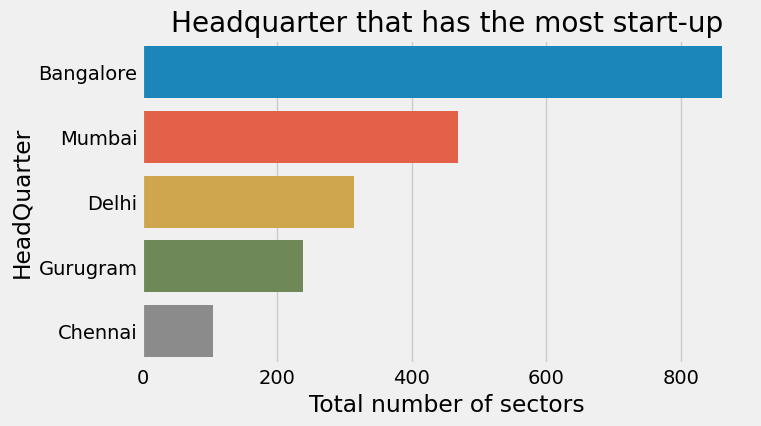

In [229]:
plt.figure(figsize=(7, 4))
plt.title('Headquarter that has the most start-up')
plt.style.use('fivethirtyeight')
sns.barplot(y='HeadQuarter', x='Sector', palette=None, data=most_pop_location.iloc[:5], orient='h', hue='HeadQuarter')

plt.ylabel('HeadQuarter')
plt.xlabel('Total number of sectors')
plt.show()

# Question2

<b> top 10 headquarter that has the highest start up funding<b>

In [230]:
top_10_startup_amount = india_startup_df.groupby('HeadQuarter')['Amount'].sum().reset_index()
top_10_startup_amount = top_10_startup_amount.sort_values(by='Amount', ascending=False)
top_10_startup_amount.head(10)

,HeadQuarter,Amount
8,Bangalore,22478744358
41,Jaipur,6006575000
23,Delhi,5611701904
35,Gurugram,4833831500
12,Bengaluru,4085066198
34,Gurgaon,2305949352
73,Pune,2109737145
99,Undisclosed,1343221600
65,Noida,1227847000
26,Faridabad,1220000000


<function matplotlib.pyplot.show(close=None, block=None)>

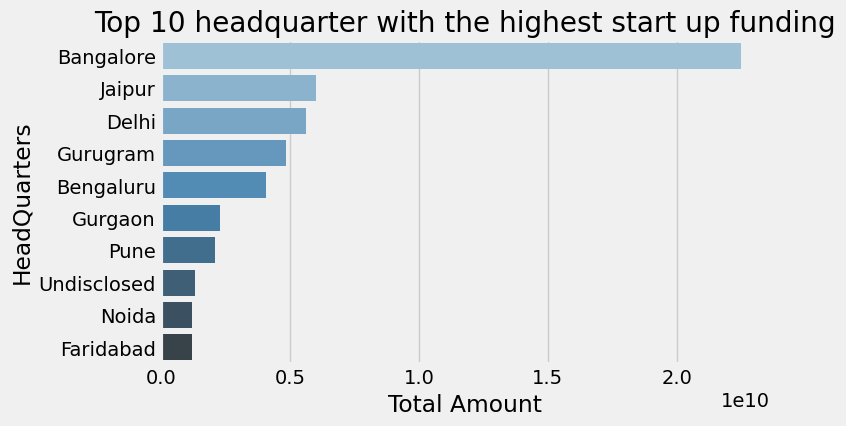

In [231]:
plt.figure(figsize=(7,4))
plt.title('Top 10 headquarter with the highest start up funding')
plt.style.use('fivethirtyeight')
sns.barplot(x='Amount',y='HeadQuarter', palette='Blues_d', data=top_10_startup_amount.iloc[:10])

plt.ylabel('HeadQuarters')
plt.xlabel('Total Amount')

plt.show

# Question 3

<b>top 10 sector that recieve the highest start up funding<b>

In [232]:
top_10_sector_amount = india_startup_df.groupby('Sector')['Amount'].sum().reset_index()
top_10_sector_amount = top_10_sector_amount.sort_values(by='Amount', ascending=False)
top_10_sector_amount.head(10)



,Sector,Amount
331,Internet Services,4137742500
193,E-Commerce,3396960000
299,Health Care,2734647145
506,Transport Services,2428250000
490,Technology,2396917756
302,Home,2272200000
542,—,2036250000
36,Automotive,2035600000
216,"Energy, Solar",2000000000
196,E-commerce,1983832000


<function matplotlib.pyplot.show(close=None, block=None)>

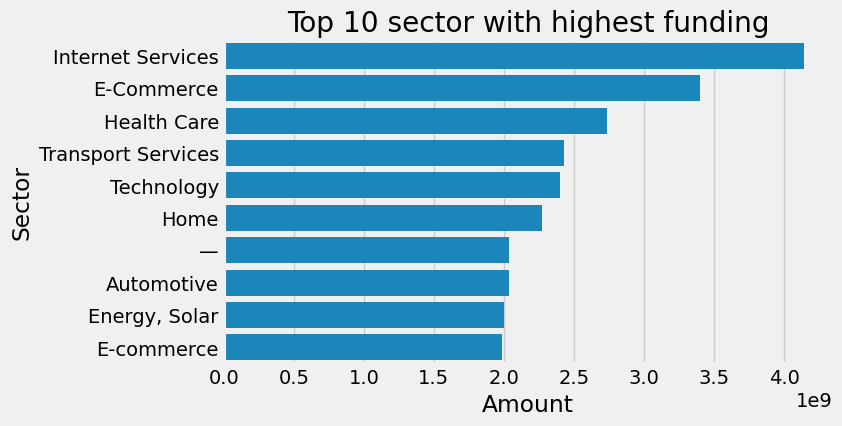

In [233]:
plt.figure(figsize=(7,4))
plt.title('Top 10 sector with highest funding')
plt.style.use('fivethirtyeight')

sns.barplot(y='Sector', x='Amount', palette=None, data=top_10_sector_amount.iloc[:10])

plt.ylabel('Sector')
plt.xlabel('Amount')  

plt.show

# Question 4

<b>Which year recieved has the most start up funding<b>

In [234]:
india_startup_df['Amount'].sum()

54926302815

In [235]:
year_startup_funding=india_startup_df.groupby('Year')['Amount'].mean().reset_index()
year_startup_funding=year_startup_funding.sort_values(by='Amount', ascending=False)
year_startup_funding

,Year,Amount
0,2018,4.491614e+07
1,2019,3.748801e+07
3,2021,1.674263e+07
2,2020,7.811779e+06


<function matplotlib.pyplot.show(close=None, block=None)>

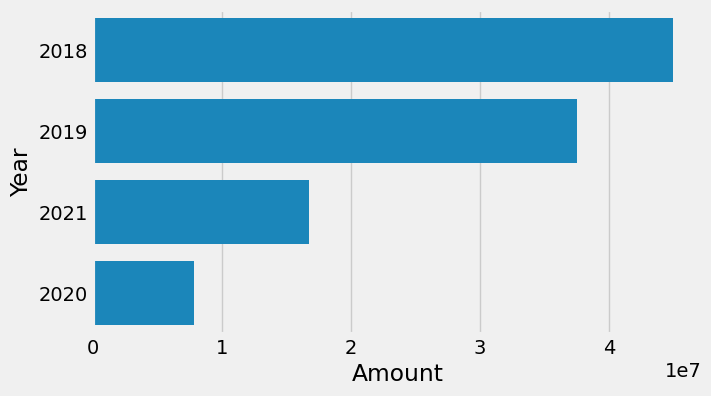

In [236]:
plt.figure(figsize=(7,4))

sns.barplot(y='Year',x='Amount',palette=None, data=year_startup_funding)

plt.show

# Question 5

<b>What is the funding trend in the Indian start-up ecosystem over the past few years<b>

In [237]:
# Get the Sum

total_funding = india_startup_df.groupby('Year')['Amount'].mean()

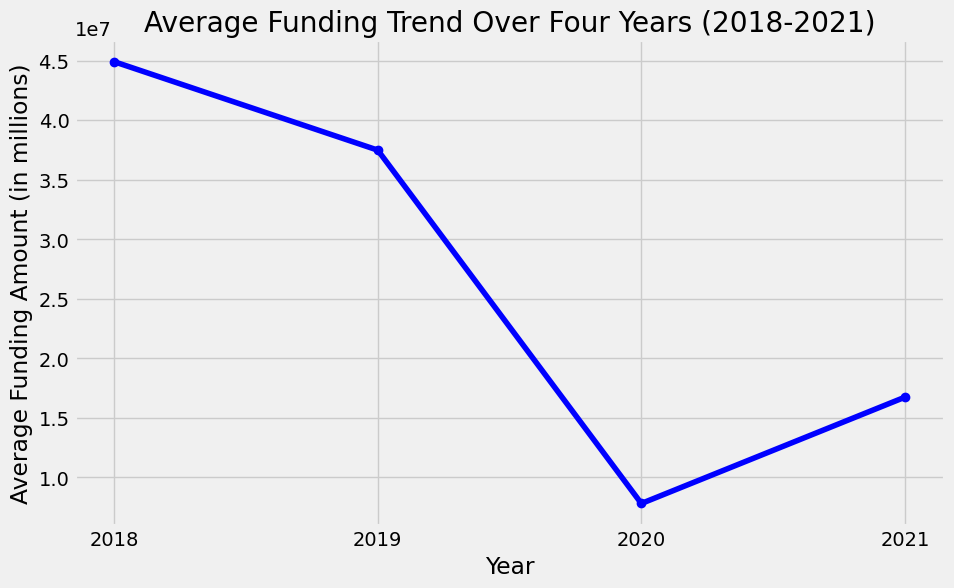

In [238]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding.index, total_funding.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Funding Amount (in millions)')
plt.title('Average Funding Trend Over Four Years (2018-2021)')
plt.grid(True)
plt.show()

# Hypothesis

Ho:Location of the sector has effect on the amount of start up funding

H1:Locattion of the sector dose not have any effect on the start up funding

From the analysis we find out that location has no effect on the amount of start of funding because Bangalore has the highest sector location but Mumbai has the highest start-up funding

1. which Head quarter has the most start up located
2. top 10 headquarter that has the highest start up funding
3. top 10 sector recieve the most start up funding
4. which year has the most highest funding
5. What is the funding trend in the Indian start-up ecosystem over the past few years

In [239]:
import pandas as pd
from io import StringIO

# Assuming india_startup_df is your DataFrame

# Convert the DataFrame to a CSV-formatted string
csv_data = india_startup_df.to_csv(index=False)

# Read the CSV-formatted string using StringIO
df = pd.read_csv(StringIO(csv_data))

# Specify the file path where you want to save the CSV file
csv_file_path = "output.csv"

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print(f"CSV file '{csv_file_path}' has been created.")



CSV file 'output.csv' has been created.


In [240]:
df = pd.read_csv('output.csv')

In [241]:
df

,Company_Brand,Sector,Stage,BIO,Year,HeadQuarter,Amount
0,TheCollegeFever,Marketing Services,Seed,"TheCollegeFever is a hub for fun, fiesta and f...",2018,Bangalore,250000
1,Happy Cow Dairy,Agriculture,Seed,A startup which aggregates milk from dairy far...,2018,Mumbai,40000000
2,MyLoanCare,Financial Services,Series,Leading Online Loans Marketplace in India,2018,Gurgaon,65000000
3,PayMe India,Financial Services,Angel,PayMe India is an innovative FinTech organizat...,2018,Noida,2000000
4,Eunimart,E-Commerce,Seed,Eunimart is a one stop solution for merchants ...,2018,Hyderabad,0
...,...,...,...,...,...,...,...
2842,Gigforce,Staffing & Recruiting,Series,A gig/on-demand staffing company.,2021,Gurugram,3000000
2843,Vahdam,Undisclosed,Series,VAHDAM is among the world’s first vertically i...,2021,Delhi,20000000
2844,Leap Finance,Financial Services,Series,International education loans for high potenti...,2021,Bangalore,55000000
2845,CollegeDekho,Technology,Series,"Collegedekho.com is Student’s Partner, Friend ...",2021,Gurugram,26000000


Hypothesis 
Hypothesis:  What the company dose depends on the amount of funding secured
Null Hypothesis: What the company dose not have infulence  on the amount of funding secured 

  Hypothesis 
Hypothesis:  The amount of start up funding has infulence on the kind of investors 

Null Hypothesis: The amount of start up funding has no significance infulence on the investors 